# Name : Pat O'Dowd

# ID : 8273375

# Train on individual category

A Resnet model is trained on a category of images (eg filled squares/triangles) and evaluated with outline and Kanizsa squares and triangles

Test 3 – Train model and evaluate based on training data

# 1. Install & Import Packages

In [1]:

!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import confusion_matrix

# Common Functions

In [3]:
# Function to evaluare model based on a test dataset. Returns predicted and true
def evaluateModel():
    batch_size=1
    store_predictions = []
    store_labels = []
    model.eval()
    num_test_batches=len(test_dataloader)
    for i, data in enumerate(test_dataloader, 0):
# basic training loop
        input_batch, label_batch = data
        input_batch = input_batch.to(device)

        pred_logit = model(input_batch)
#        print("pred logit 1",pred_logit)
        predictions = torch.argmax(pred_logit,1) # reduce along output dimension
        predictions_np = predictions.to("cpu").numpy()
        label_batch_np = label_batch.numpy()
        if i<num_test_batches-1:
            store_predictions.append(predictions_np)
            store_labels.append(label_batch_np)

    y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*batch_size)))
    y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*batch_size)))
    print(y_true)

    return(y_pred,y_true)

# ADDED - Added method to get prediction from image.
def getPrediction(image,model):


    pred_logit = model(image) 
    opFeatures = pred_logit['op_features']
    opLogits = pred_logit['op_logits']
    probabilities = nn.functional.softmax(opLogits, dim=1)
    
#    predictions = torch.argmax(opLogits) # reduce along output dimension

    return opFeatures,opLogits,probabilities



# ADDED - Added method to get class activation map
# Parameters are the features, logits,the number of TopN to return and also the topN class to select.
def getCAM(opFeatures,opLogits,topN,classIndex):

# Get the topN values and classes.
    values,curr_class = torch.topk(opLogits, topN)
    probabilities = nn.functional.softmax(opLogits, dim=1)
#    print("probabilities : ",probabilities)

    batchSize,numChannels,Height,Width = opFeatures.shape
    selectedClass = curr_class[0][classIndex]
#    selectedValue = values[0][classIndex]
    selectedValue = probabilities[0][selectedClass] * 100
    sd = model.state_dict()
# Get the weights for the selected classs
    logit_layer_weight = logit_layer + '.weight'
    weights = sd[logit_layer_weight][selectedClass]
    HW_trg =224
    scaleFactor = HW_trg/7
# Calculate the class activation map by 
# 1. Multiplying the weights by the features
# 2 Summing the weights
# 3 Reshaping back into an image vector 
# 4 upsammpling the image to its original size. 
    cam = weights.reshape(numChannels,1)*(opFeatures.reshape(numChannels,Height*Width))
    camSummed = torch.sum(cam,dim=0)
    camSummed = camSummed.reshape(1,1,Height,Width)
    upSample = torch.nn.Upsample(scale_factor=scaleFactor,mode='bilinear')
    HW_trg=224
    act_map_us = upSample(camSummed).to("cpu").reshape(HW_trg,HW_trg,1)     

    return act_map_us,selectedClass,selectedValue


def unnormalize_image(image, mean, std):
    """
    Unnormalize a PyTorch image tensor.

    Args:
        image (torch.Tensor): The normalized image tensor of shape [C, H, W].
        mean (list or tuple): The mean used for normalization.
        std (list or tuple): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The unnormalized image tensor.
    """
    # Remove the batch dimension
    image = image.squeeze(0)

    # Check if the image is in the shape [C, H, W]
    if image.dim() == 3:
        # Unnormalize the image
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
    else:
        raise ValueError("Expected image tensor of shape [C, H, W]")

    # Convert from [C, x, y] to [x, y, C]
    orig_image = image
    image = image.permute(1, 2, 0)
    return image,orig_image


# Plot the Class activation images
def plot_cam(model,labels):
# Initialize Figure
    fig = plt.figure(figsize=(11,11), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
    model.eval()
    j = 0

    for i in range(0,7):
        dataiter = iter(test_dataloader)   
        z = next(dataiter)

        z_img = z[0].to(device)
        img = z[0]
        actuallabel = z[1].numpy()[0]


   
        opFeatures,opLogits,probabilities = getPrediction(z_img,model)
        topN = 2
        selectedClass = 0
        act_map_us,curr_class,curr_value = getCAM(opFeatures,opLogits,topN,selectedClass)
 
    # N. Plotting

        def get_value(dictionary, key):
            try:
                return dictionary[key]
            except KeyError:
                return "Error"

        pred_logit = model(z_img)['op_logits']
        predictions = torch.argmax(pred_logit,1) # reduce along output dimension
        predictions_np = predictions.to("cpu").numpy()

        
        curr_label = int(curr_class)
        if actuallabel == curr_label:
            title_color = 'green'
        else:
            title_color = 'red'
        label = get_value(labels,int(curr_class))
        label = label + " - " + str(int(curr_value))


        img,orig_image=unnormalize_image(img,mean,std)

        ax = fig.add_subplot(5, 7, j + 1, xticks=[], yticks=[])
        ax.set_title(label,color=title_color,fontsize=10)
        ax.imshow(img)
        plt.imshow(img)
        plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.2)
        j=j+1



    plt.show()

    return

def plot_cam_topn(model,labels):
# Initialize Figure
    fig = plt.figure(figsize=(11,11), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
    model.eval()
    j = 0

    for i in range(0,5):
        dataiter = iter(test_dataloader)   
        z = next(dataiter)

        z_img = z[0].to(device)
        img = z[0]
        actuallabel = z[1].numpy()[0]


   
        opFeatures,opLogits,probabilities = getPrediction(z_img,model)
        topN = 4
        selectedClass = 0
        img,orig_image=unnormalize_image(img,mean,std)
        ax = fig.add_subplot(5, 5, j + 1, xticks=[], yticks=[])
        ax.set_title('Original',fontsize=8)        
        ax.imshow(img)
        j= j+ 1

        for k in range(topN):
            act_map_us,curr_class,curr_value = getCAM(opFeatures,opLogits,topN,k)
 
    # N. Plotting

            def get_value(dictionary, key):
                try:
                    return dictionary[key]
                except KeyError:
                    return "Error"

            pred_logit = model(z_img)['op_logits']
            predictions = torch.argmax(pred_logit,1) # reduce along output dimension
            predictions_np = predictions.to("cpu").numpy()

        
            curr_label = int(curr_class)
            if actuallabel == curr_label:
                 title_color = 'green'
            else:
                 title_color = 'red'
            title_color = 'green'
            label = get_value(labels,int(curr_class))
            label = label + " - " + str(int(curr_value))




            ax = fig.add_subplot(5, 5, j + 1, xticks=[], yticks=[])
            ax.set_title(label,color=title_color,fontsize=10)
            ax.imshow(img)
            plt.imshow(img)
            plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.2)
            j=j+1



    plt.show()

    return



## 2. Setup & Import Dataset





In [4]:

# Define transformations for image pre-processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [5]:
batch_size=64

## Load Content data set comprising 7 categories of Shape images

In [6]:
# Load Dataset for training.
image_dataset = torchvision.datasets.ImageFolder(root='Content/',transform=transform)
#image_dataset = torchvision.datasets.ImageFolder(root='Kanizsa/',transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [0.8, 0.2])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
train1_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [0.8, 0.2])
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)




In [7]:
# Shoe shape of data.

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


In [8]:
print('Test Samples ',len(val_dataloader.dataset))
print('Train Samples ',len(train_dataloader.dataset))
print('Test Batches ',len(val_dataloader))
print('Train Batches ',len(train_dataloader))

Test Samples  11970
Train Samples  47880
Test Batches  188
Train Batches  749


Plot some example images from the data set

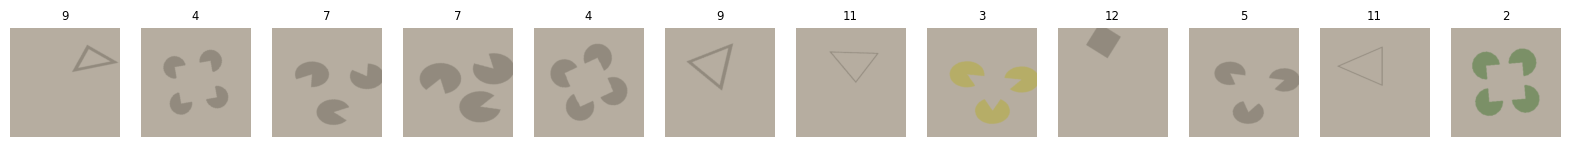

In [9]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Train pre-trained model



In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device=("cpu")
print(f"Using {device} device")

Using cuda device


## Train ResNet with 14 output classification nodes.

In [11]:
# Loading the pre-trained model and adding in the new fully connected layers
pretrained_resnet = models.resnet18(weights='IMAGENET1K_V1')
imagenette_labels = {key: val for key, val in enumerate(models.ResNet18_Weights.DEFAULT.meta["categories"])}
class MyResNet(nn.Module):
    def __init__(self, my_pretrained_model):
        super(MyResNet, self).__init__()
        self.pretrained = my_pretrained_model
        self.my_new_layers = nn.Sequential(nn.Linear(1000, 512),
                                           nn.ReLU(),
                                           nn.Linear(512, 14))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

my_resnet = MyResNet(my_pretrained_model=pretrained_resnet)
my_resnet
# model = my_resnet.to(device)
my_resnet = my_resnet.to(device)
model = my_resnet

In [12]:
from torchinfo import summary
# Ensure input size is correct
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
MyResNet                                      [64, 14]                  --
├─ResNet: 1-1                                 [64, 1000]                --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [64, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [64, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [64, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [64, 128, 28, 28]         230,144
│    │    └─BasicBlock: 3-4                   [64, 128, 28, 28]         295,42

In [13]:
# Get names of model nodes. Used to select layer for CAM.
train_nodes, eval_nodes = get_graph_node_names(model)
print(train_nodes)

['x', 'pretrained.conv1', 'pretrained.bn1', 'pretrained.relu', 'pretrained.maxpool', 'pretrained.layer1.0.conv1', 'pretrained.layer1.0.bn1', 'pretrained.layer1.0.relu', 'pretrained.layer1.0.conv2', 'pretrained.layer1.0.bn2', 'pretrained.layer1.0.add', 'pretrained.layer1.0.relu_1', 'pretrained.layer1.1.conv1', 'pretrained.layer1.1.bn1', 'pretrained.layer1.1.relu', 'pretrained.layer1.1.conv2', 'pretrained.layer1.1.bn2', 'pretrained.layer1.1.add', 'pretrained.layer1.1.relu_1', 'pretrained.layer2.0.conv1', 'pretrained.layer2.0.bn1', 'pretrained.layer2.0.relu', 'pretrained.layer2.0.conv2', 'pretrained.layer2.0.bn2', 'pretrained.layer2.0.downsample.0', 'pretrained.layer2.0.downsample.1', 'pretrained.layer2.0.add', 'pretrained.layer2.0.relu_1', 'pretrained.layer2.1.conv1', 'pretrained.layer2.1.bn1', 'pretrained.layer2.1.relu', 'pretrained.layer2.1.conv2', 'pretrained.layer2.1.bn2', 'pretrained.layer2.1.add', 'pretrained.layer2.1.relu_1', 'pretrained.layer3.0.conv1', 'pretrained.layer3.0.bn1',

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.


In [14]:
# Set the training parameters.
loss_fn = nn.CrossEntropyLoss()

# MODIFIED : Optimizer changed to Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ADDED : Added Scheduler using OneCycleLR. 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002,steps_per_epoch=batch_size,epochs=10)

## Train the model

In [15]:
n_iter =100   # Set how frequently will return loss (must be less than test_size)
# MODIFIED : Modified epochs to 10
n_epochs = 1 # Set total number of epoochs
train_size = len(train_dataloader.dataset)
val_size = len(val_dataloader.dataset)
num_val_batches = len(val_dataloader)



for epoch in range(n_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # basic training loop
        inputs, labels = data


        labels = torch.squeeze(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()

        optimizer.step()


        optimizer.zero_grad()

        running_loss += loss.item()
        running_acc += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        if i % n_iter == n_iter-1:    # Every n mini-batches...
            print('Epoch {}'.format(epoch),' Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            running_vacc = 0.0
            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(val_dataloader, 0):

                vinputs, vlabels = vdata
                vlabels = torch.squeeze(vlabels)
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()
                running_vacc += (voutputs.argmax(1) == vlabels).type(torch.float).sum().item()
            model.train(True) # Switching back to training mode, eg. turning on regularisation

            avg_loss = running_loss / n_iter  # Compute loss over n_iter iterations
            avg_acc = 100*running_acc / (n_iter*batch_size) # number of examples computing accuracy over
            avg_vloss = running_vloss / num_val_batches
            avg_vacc = 100*running_vacc / val_size
            running_loss = 0.0
            running_acc = 0.0
#ADDED : Captured Learning rate so it can be plotted against loss.
            lr_step = scheduler.get_last_lr()
            # Print intermediate results
            print(f"Training Error: \n Accuracy: {(avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
            print(f"Validation Error: \n Accuracy: {(avg_vacc):>0.1f}%, Avg loss: {avg_vloss:>8f} \n")


#    scheduler.step()



print('Finished Training')



Epoch 0  Batch 100
Training Error: 
 Accuracy: 92.3%, Avg loss: 0.330528 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.120426 

Epoch 0  Batch 200
Training Error: 
 Accuracy: 96.0%, Avg loss: 0.137331 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.116935 

Epoch 0  Batch 300
Training Error: 
 Accuracy: 96.5%, Avg loss: 0.118839 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.122890 

Epoch 0  Batch 400
Training Error: 
 Accuracy: 95.9%, Avg loss: 0.137455 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.119700 

Epoch 0  Batch 500
Training Error: 
 Accuracy: 96.2%, Avg loss: 0.125657 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.118673 

Epoch 0  Batch 600
Training Error: 
 Accuracy: 96.3%, Avg loss: 0.124177 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.119817 

Epoch 0  Batch 700
Training Error: 
 Accuracy: 96.3%, Avg loss: 0.123848 

Validation Error: 
 Accuracy: 96.4%, Avg loss: 0.123057 

Finished Training


# 5. Evaluate Model
Model is evaluated with the test data sets.



In [26]:
# Function to generate and plot the CAM.
def generate_cam(classes):
    feature_layer = 'pretrained.layer4.1.conv2'
    logit_layer = 'pretrained.fc'
    logit_layer = 'my_new_layers.2'
# Verity Dataloader & Image
    dataiter = iter(train_dataloader)
    z = next(dataiter)
#print(np.shape(z[0]))

#    img,orig_image=unnormalize_image(z[0][0],mean,std)
#    plt.imshow(img)
#print(img.shape)
    train_nodes, eval_nodes = get_graph_node_names(model)
#print(train_nodes)

# Define Dictionary of output nodes
    return_nodes={feature_layer :'op_features',logit_layer :'op_logits'}

# Create new model using the return nodes
    cam_model=create_feature_extractor(model, return_nodes=return_nodes)
    z[0] = z[0].to(device)

#print("SD ",sd)
#pass data through model
    out=cam_model(z[0].to(device))
#print([(k, v.shape) for k, v in out.items()])
    HW_trg =224
    scaleFactor = HW_trg/7
    plot_cam_topn(cam_model,classes)
    return

In [27]:
# Function to print confusoin matrix.
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [28]:
model_original = model


In [29]:
# Function to load new dataset.
def load_dataset(rootDir):
    batch_size=64
    image_dataset = torchvision.datasets.ImageFolder(root=rootDir,transform=transform)
    train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [0.8, 0.2])
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
    train1_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [0.7, 0.3])
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
    classes = image_dataset.classes
    return image_dataset,train_dataloader,test_dataloader,classes

In [30]:
# Set the feature and logit layers. This may change dependent on the pre-trained model used. eg Resnet18 vs Resnet50
feature_layer = 'pretrained.layer4.1.conv2'
logit_layer = 'pretrained.fc'
logit_layer = 'my_new_layers.2'

## Evaluate the model with the original data set.

[ 8  3  1 ...  7  7 12]
              precision    recall  f1-score   support

    C_Square       1.00      0.86      0.93      1206
  C_Triangle       1.00      0.89      0.94      1358
   KC_Square       1.00      0.87      0.93      1250
 KC_Triangle       1.00      0.87      0.93      1292
    K_Square       0.89      1.00      0.94      1213
  K_Triangle       0.89      1.00      0.94      1367
   NK_Square       1.00      1.00      1.00      1197
 NK_Triangle       1.00      1.00      1.00      1364
   OT_Square       1.00      1.00      1.00      1208
 OT_Triangle       1.00      1.00      1.00      1271
    O_Square       1.00      1.00      1.00      1245
  O_Triangle       1.00      1.00      1.00      1368
      Square       0.88      1.00      0.94      1228
    Triangle       0.90      1.00      0.95      1387

    accuracy                           0.96     17954
   macro avg       0.97      0.96      0.96     17954
weighted avg       0.97      0.96      0.96     17954



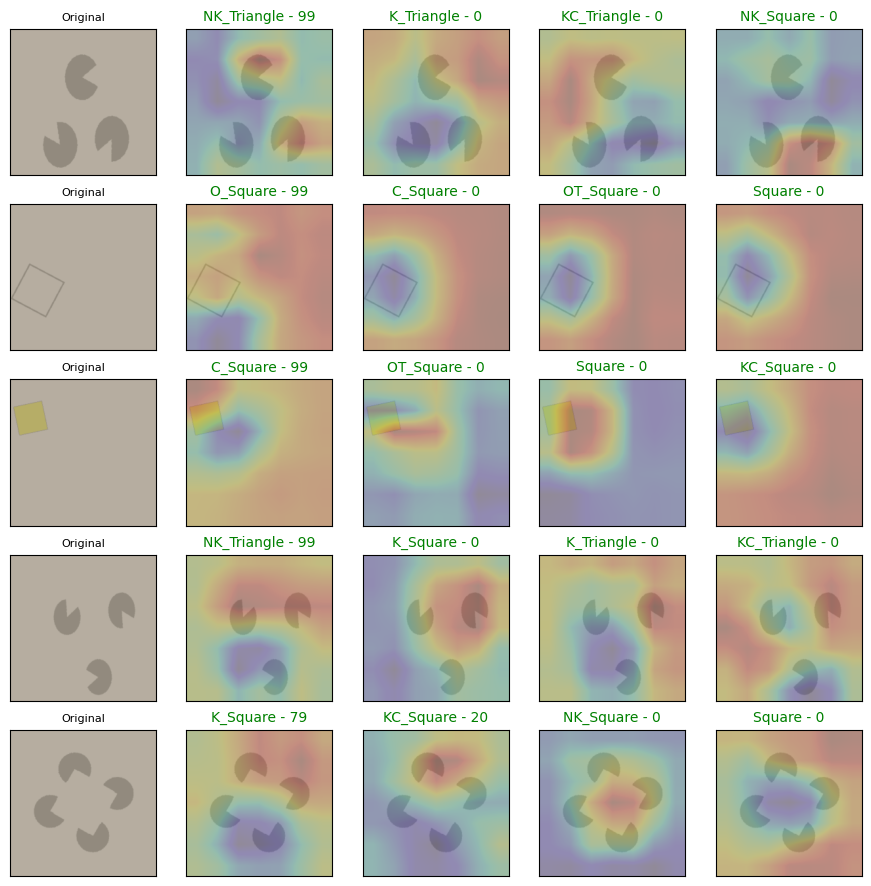

In [31]:
image_dataset,train_dataloader,test_dataloader,classes = load_dataset('Content/')
y_pred,y_true = evaluateModel()
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
generate_cam(classes)

In [32]:
allClasses = classes

## Test with sample test data copied from original test data set.

[0 0 1 0 0 0 0 0 0 0 0]


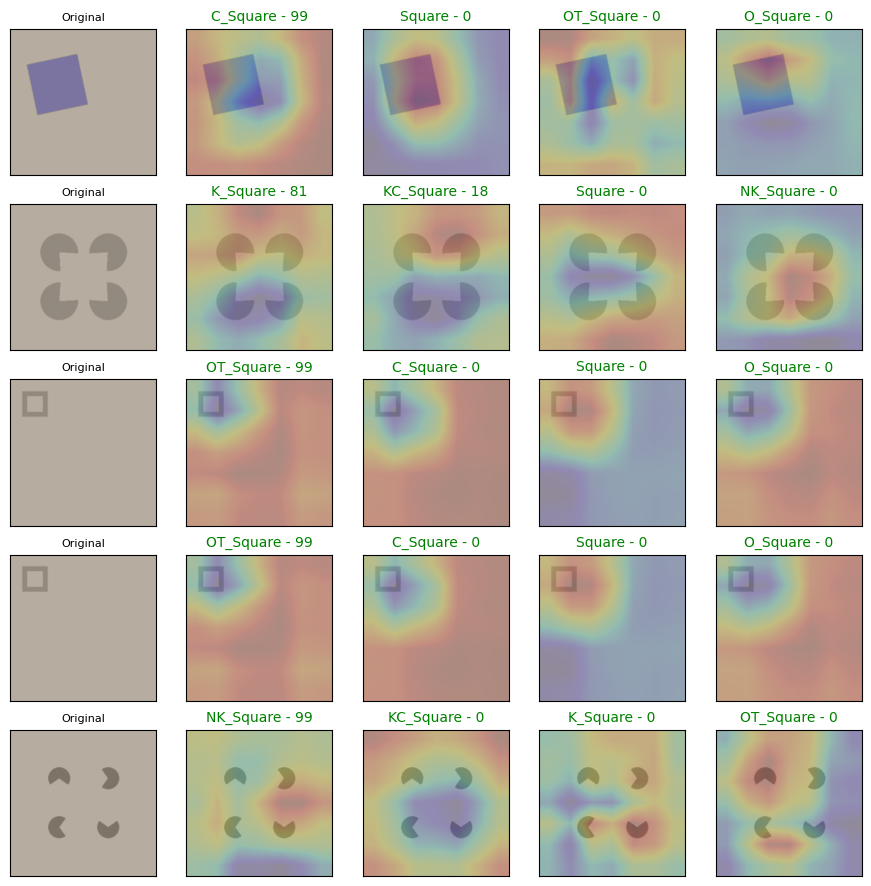

In [45]:
image_dataset,train_dataloader,test_dataloader,classes = load_dataset('TestData/')
y_pred,y_true = evaluateModel()
from sklearn.metrics import classification_report
#print(classification_report(y_true, y_pred, target_names=classes))
#cm = confusion_matrix(y_true, y_pred)
generate_cam(allClasses)

## Test with reverse Kanizsa images.

[0 0 0 ... 0 0 0]


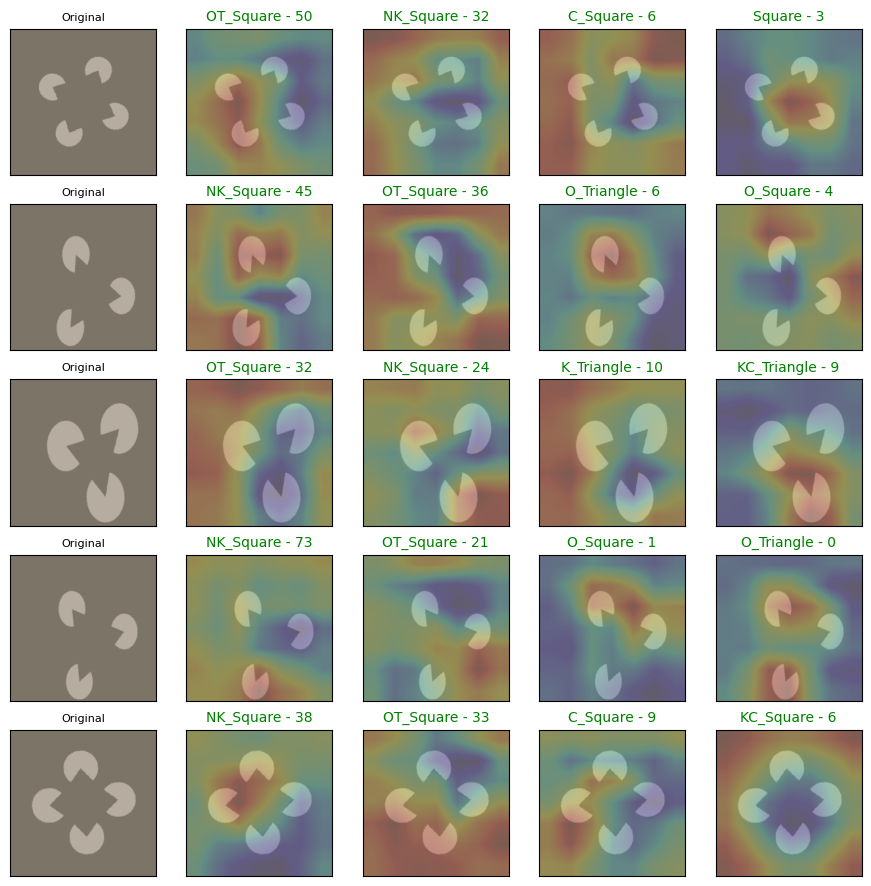

In [46]:
image_dataset,train_dataloader,test_dataloader,classes = load_dataset('ReverseKanizsa/')
y_pred,y_true = evaluateModel()
from sklearn.metrics import classification_report
#print(classification_report(y_true, y_pred, target_names=classes))
#cm = confusion_matrix(y_true, y_pred)
generate_cam(allClasses)

## Test with reverse filled images

[1 0 0 ... 1 0 0]


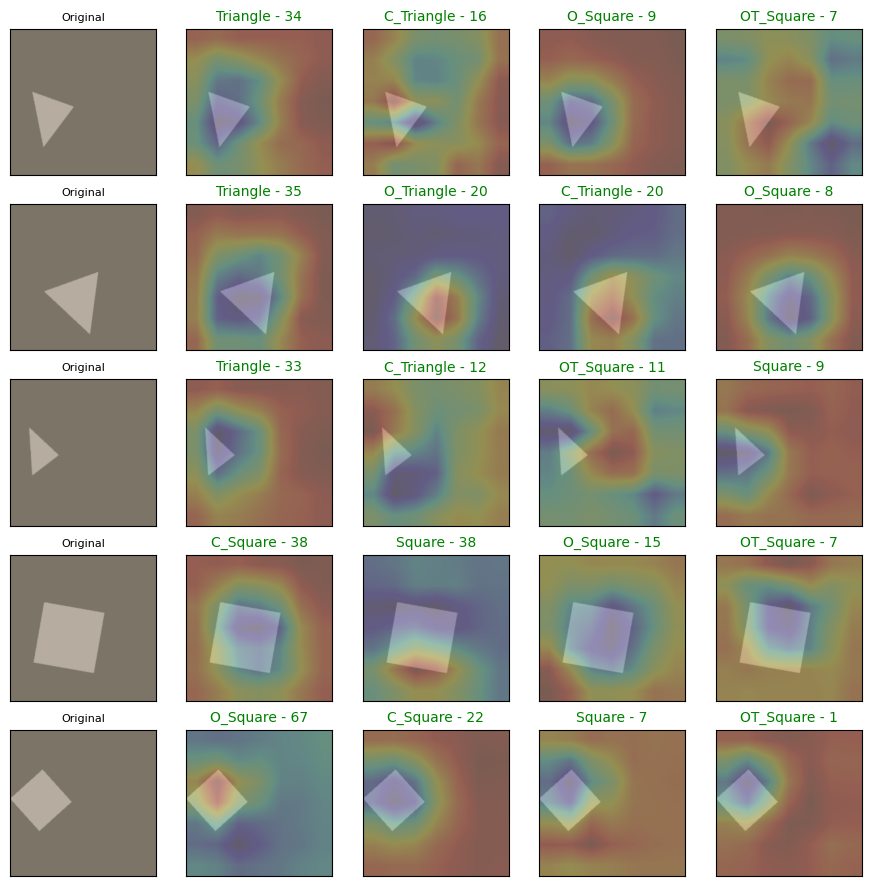

In [56]:
image_dataset,train_dataloader,test_dataloader,classes = load_dataset('ReverseFilled/')
classes=allClasses
y_pred,y_true = evaluateModel()
from sklearn.metrics import classification_report
generate_cam(allClasses)